# Examples of using PCV package for Python

This notebook contains code examples for `prcv` package — implementation of Procrustes cross-validation method in Python. The code creates plots similar to what you can see on some of the figures with Corn example in [this paper](https://doi.org/10.1016/j.aca.2023.341096). Check the project repository for more details: [https://github.com/svkucheryavski/pcv/](https://github.com/svkucheryavski/pcv/).

To run code from this notebook, first of all make sure that you have downloded data file, `data.csv`, and file with helper functions, `misc.py`, from [`demo` folder](https://github.com/svkucheryavski/pcv/Python/demo) of the repository, and have both files in the same folder as this notebook.

Second important thing is that you have already installed the package `prcv`. You can do it, for example, by running `pip install prcv`.

First of all let's import all necessary packages as well as the helper functions from `misc.py`:

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from prcv.methods import pcvpca, pcvpcr, pcvpls

# load helper functions from misc.py
from misc import scale, pca_fit, pca_predict, plot_distances, \
    pls_fit, pls_predict, plot_plsres, plot_predictions

Now let's load the dataset, which we then split to predictors, `X`, and responses, `Y`:

In [11]:
D = np.genfromtxt('corn.csv', delimiter=',')
X = D[:, 1:]
Y = D[:, :1]

## PCA based examples

In this section we will show how to generate PV-set using PCA decomposition and how to use the generated dataset for validation. Here is the code to create a PV-set:

In [12]:
Xpv = pcvpca(X, ncomp = 30, cv = {'type': 'ven', 'nseg': 4})

As you can see, we used 30 principal components in PCA model and cross-validation resampling with four segments and Venetian blinds split. Parameters `center` and `scale` were not specified explicitly, hence default values are used (`center = True`, `scale = False`).

Now let's create a global PCA model using the original calibration set and then project both datasets to the model and get dictionary with results. In order to do that we will use two helper functions, `pca_fit()` and `pca_predict()` which are defined in file `misc.py`:

In [13]:
m = pca_fit(X, 20)
res_cal = pca_predict(m, X)
res_pv = pca_predict(m, Xpv)

Now, let's create plots with two distances — orthogonal distance, $q$, and score distance, $h$, for each of the results and show distance plots. Again we will use a helper function from `misc.py` for that. The distance values are scaled to average distance ($h_0$ and $q_0$). First plot is created for $A = 2$ components in the model. Second plot is created for $A = 20$ components:

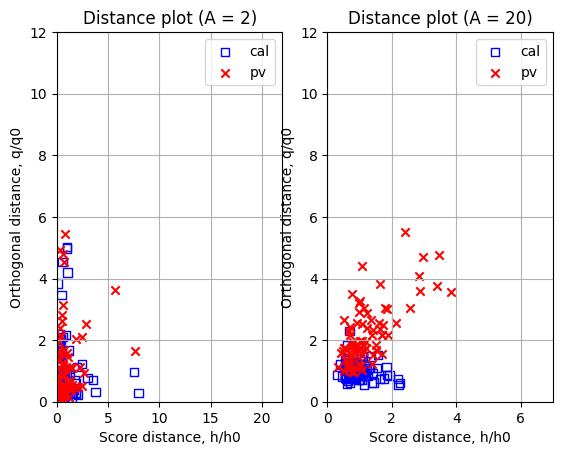

In [14]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1, ncols = 2)
plot_distances(res_cal = res_cal, res_pv = res_pv, ncomp =  2, xlim = [0, 22], ylim = [0, 12], ax = ax1)
plot_distances(res_cal = res_cal, res_pv = res_pv, ncomp = 20, xlim = [0,  7], ylim = [0, 12], ax = ax2)
plt.show()

As you can see, in case with $A = 20$ the PV-set points show clear signs of overfitting. This plot is similar to what you can see in Supplementary materials of [the paper](https://doi.org/10.1016/j.aca.2023.341096).

## PCR based examples

In this section we will show PCR based example by generating PV-set using PCR decomposition and then compare the generated PV-set with the original calibration set, as it is also shown on Figure 2 of [the paper](https://doi.org/10.1016/j.aca.2023.341096).

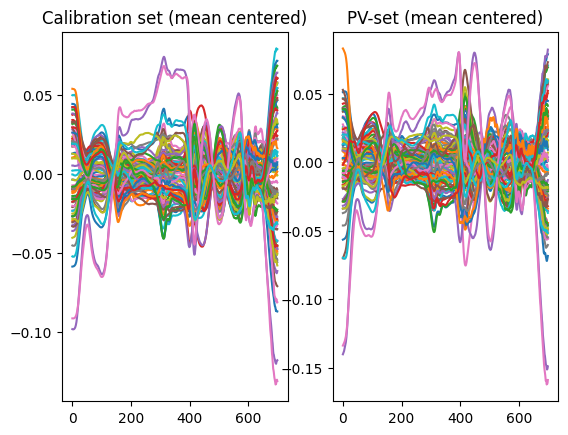

In [15]:
Xpv, D = pcvpcr(X, Y, ncomp = 20, cv = {'type': 'ven', 'nseg': 4})

plt.subplot(121)
plt.plot(scale(X).T)
plt.title('Calibration set (mean centered)')

plt.subplot(122)
plt.plot(scale(Xpv).T)
plt.title('PV-set (mean centered)')

plt.show()

Notice, that PCR version has two outcomes: the PV-set (`Xpv`) and matrix with scalars (`D`).

Same parameters for PCV algorithm as in case of PCA were used. Both datasets were mean centered using helper function `scale()` from file `misc.py`.

## PLS based examples

Finally let's generate a PV-set by using PLS based algorithm:

In [16]:
Xpv, D = pcvpls(X, Y, ncomp = 20, cv = {'type': 'ven', 'nseg': 4})

As in the previous case, we got two outcomes, a PV-set (`Xpv`) and a matrix with scalars (`D`). Let's use the generated PV-set as validation set for a global PLS model. The code below creates such a model and makes predictions for calibration and PV-sets using helper functions from `misc.py`:

In [17]:
m = pls_fit(X, Y, ncomp = 20)
res_cal = pls_predict(m, X, Y)
res_pv = pls_predict(m, Xpv, Y)

Now let's make a figure, similar to Figure 5 of [the paper](https://doi.org/10.1016/j.aca.2023.341096) with two predicted vs. measured plots (for $A = 10$ and for $A = 20$) and RMSE plot vs. number of components. Again we will use helper functions for that:

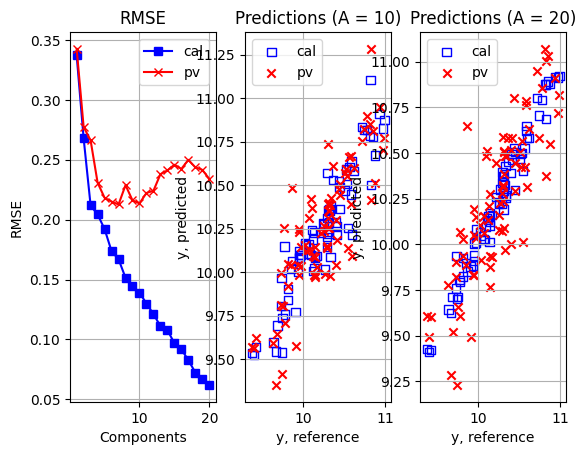

In [18]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows = 1, ncols = 3)
plot_plsres(res_cal = res_cal, res_pv = res_pv, ax = ax1, type = "RMSE", title = "RMSE")
plot_predictions(res_cal = res_cal, res_pv = res_pv, ax = ax2, ncomp = 10)
plot_predictions(res_cal = res_cal, res_pv = res_pv, ax = ax3, ncomp = 20)
plt.show()

Again we can see that PV-set is well suited for validation.

Finally let's visualize the matrix with scalars $c_k/c$ (`D`) by using heatmap and a boxplot, similar to what is shown in Figure 6 of the paper.

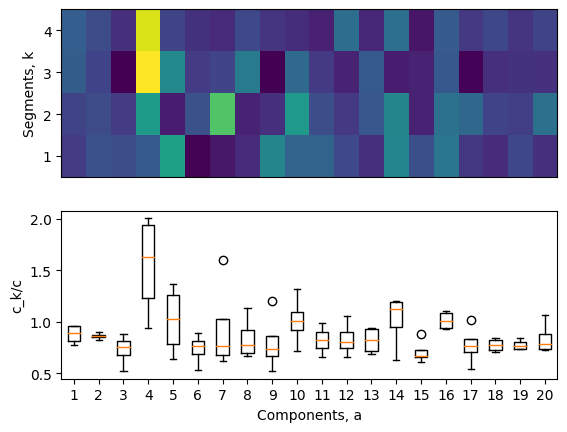

In [19]:
plt.subplot(211)
plt.imshow(D[::-1, :], aspect = 'auto', extent = (0.5, D.shape[1] + 0.5, 0.5, D.shape[0] + 0.5))
plt.xticks([])
plt.yticks(range(1, D.shape[0] + 1))
plt.ylabel('Segments, k')

plt.subplot(212)
plt.boxplot(D)
plt.ylabel('c_k/c')
plt.xlabel('Components, a')

plt.show()